## Challenge 2: Multi-class Image Classification

Table of Contents:
1. Imports
2. Functions
3. Feature Extraction
4. Exploratory Data Analysis (EDA)
5. 

#### 1. Imports

In [19]:
# To hide deprication warnings 
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Append helpers module to use the implemented modules from there
import sys
sys.path.append('../helpers/')

from pathlib import Path
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import natsort
import cv2
import csv
import random
import pprint
import seaborn as sns
import subprocess

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, cohen_kappa_score, multilabel_confusion_matrix, balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from scipy.stats import mode, skew, kurtosis, entropy
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

# imported from helpers module
from feature_selection import FeatureSelection
from preprocessing import Preprocessing

# fe              = FeatureExtraction()
preprocessor    = Preprocessing()
select_feature  = FeatureSelection()

# PPrint object
pp = pprint.PrettyPrinter(indent=4)

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
    gpu = True
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')
    gpu = False

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

Init class FS {}
No Nvidia GPU in system!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2. Functions

In [2]:
def pprint_objects(*arg):
    '''Prints large and indented objects clearly.'''
    pp.pprint(arg)

def load_pickle(dir):
    try:
        with open(dir, 'rb') as file:
            return pickle.load(file)
    except:
        raise Exception(f'Error loading the pickle from {dir} directory.')


#### 3. Feature Extraction

In [6]:
class FeatureExtraction:
    def __init__(self) -> None:
        pass

    def _plot_histogram(self, hist, title='Histogram'):
        # Determine the number of bins based on the length of the histogram
        num_bins = len(hist)

        # Create an array of bin edges
        bin_edges = np.arange(num_bins)

        # Create a bar plot for the histogram
        plt.bar(bin_edges, hist)

        # Set labels and a title
        plt.xlabel('Bin')
        plt.ylabel('Frequency')
        plt.title(title)

        # Show the plot
        plt.show()



    def calculate_hist_features(self, hist):
        feature_vector = []
        
        feature_vector.append(np.dot([i for i in range(0,256)], hist)) # Mean
        feature_vector.append(np.argmax(hist)) # Mode
        feature_vector.append(np.std(hist)) # Standard deviation
        feature_vector.append(skew(hist)) # Skewness
        feature_vector.append(np.sum(hist**2)) # Energy
        feature_vector.append(entropy(hist, base=2)) # Entropy
        feature_vector.append(kurtosis(hist)) # Kurtosis

        return np.array(feature_vector)
    
    def _compute_norm_hist(self, image, bins=256, range=(0, 256), gray=False, density=True):
        if not gray:
            hist_ch1, _ = np.histogram(image[:, :, 0], bins, range, density)
            hist_ch2, _ = np.histogram(image[:, :, 1], bins, range, density)
            hist_ch3, _ = np.histogram(image[:, :, 2], bins, range, density)

            # self._plot_histogram(hist_ch1)
            
            # hist_ch1 = hist_ch1 / np.sum(hist_ch1)
            # hist_ch2 = hist_ch2 / np.sum(hist_ch2)
            # hist_ch3 = hist_ch3 / np.sum(hist_ch3)

            # self._plot_histogram(hist_ch1)

            return hist_ch1, hist_ch2, hist_ch3
        else:
            hist_gray, _ = np.histogram(image, bins, range, density)
            # hist_gray = hist_gray / np.sum(hist_gray)

            return hist_gray
    
    def extract_color_features(self, img):
        # BGR
        hist_b, hist_g, hist_r = self._compute_norm_hist(img)

        # HSV
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist_h, hist_s, hist_v = self._compute_norm_hist(hsv_img)

        # LAB
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        hist_L, hist_A, hist_B = self._compute_norm_hist(lab_img)

        # Gray
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist_gray = self._compute_norm_hist(gray_img, gray=True)

        color_features = np.concatenate((
            self.calculate_hist_features(hist_r), 
            self.calculate_hist_features(hist_g), 
            self.calculate_hist_features(hist_b),
            
            self.calculate_hist_features(hist_h), 
            self.calculate_hist_features(hist_s), 
            self.calculate_hist_features(hist_v),

            self.calculate_hist_features(hist_L),
            self.calculate_hist_features(hist_A),
            self.calculate_hist_features(hist_B),

            self.calculate_hist_features(hist_gray),
            )
        )

        return color_features
    
    def extract_glcm_features(self, image):    
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a numpy array")

        if image.dtype != np.uint8:
            # If the image is not 8-bit, convert it to 8-bit
            # important as we set the levels for glcm to 256 for 8-bit images
            image = image.astype(np.uint8)

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute GLCM matrix
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(gray_image, distances, angles, levels=256, symmetric=True, normed=True)
        
        # Extract texture features from GLCM matrix
        features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        texture_features = np.concatenate([graycoprops(glcm, feature).ravel() for feature in features])
        
        return texture_features
    
    def extract_lbp_features(self, image):
        ''' 
        Extracts the histogram of the LBP image for a certain number of neighbours and radius.

        Args:
            image (numpy.ndarray): the image from which the LBP features will be extracted (cropped ROI)
            P (int): number of neighbours
            R (int): radius
        Output:
            hist (numpy.array): histogram of the LBP image
        '''

        P=[8, 16] 
        R=[1, 2]
        histogram = []

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        for idx, P_value in enumerate(P):

            n_points = P_value * R[idx]

            lbp_image = local_binary_pattern(gray_image, n_points, R[idx], method='uniform')

            # Calculate the histogram of the LBP image
            hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2), density=True)

            # Normalize the histogram
            hist /= np.sum(hist)

            histogram = np.concatenate((histogram, hist))
        
        return histogram

    def extract_hog_features(self, image):
        """
        Extract HOG features from an input image.

        Parameters:
        - image: Input image (grayscale).

        Returns:
        - hog_features: The extracted HOG features.
        """
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        # Define HOG parameters (you can customize these as needed)
        pixels_per_cell = (8, 8)
        cells_per_block = (2, 2)
        orientations = 9

        # Compute HOG features
        hog_features = hog(gray_image, pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           orientations=orientations)
        
        return hog_features
    
    def region_based_hist_fe(self, callback_func, image):
        # We split the image into 3 parts, each is 1/3 of the original height
        height, _, _ = image.shape
        partial_height = height // 3

        # Sotring the images into a list to iterate through them and get the feature vector for each part separately
        images_list = [
            image[0:partial_height, :],
            image[partial_height:2*partial_height, :],
            image[2*partial_height:, :],
        ]

        feature_vector = []

        for img in images_list:
            partial_feature_vector = callback_func(img)
            feature_vector = np.concatenate((feature_vector, partial_feature_vector))

        return feature_vector

        
    def fit(self, image):
        # color_features      = self.extract_color_features(image)
        color_features      = self.region_based_hist_fe(
            callback_func=self.extract_color_features,
            image=image
        )
        texture_features    = self.extract_glcm_features(image)
        lbp_features        = self.extract_lbp_features(image)
        # hog_features        = self.extract_hog_features(image) # 1 file of 7k samples ended up 24GB size

        all_features = np.concatenate((color_features, texture_features, lbp_features))

        return all_features
    
fe = FeatureExtraction()


# img = r'../challenge1/train/nevus/nev00001.jpg'
# img = cv2.imread(img)

# # cv2.imshow("s", img)
# # cv2.waitKey(0)

# fv1 = fe.extract_color_features(img)
# fv2 = fe.region_based_hist_fe(fe.extract_color_features, img)

# # print(fv1)
# print(fv2)


# b,g,r = fe._compute_norm_hist(img)
# print(np.min(b))

#### 3. Feature Extraction

In [7]:
# Directories
ROOT_PATH = Path(Path(os.getcwd())/"../challenge2")
TRAIN_PATH = ROOT_PATH/"train"
VAL_PATH = ROOT_PATH/"val"

train_bcc = sorted(glob(str(TRAIN_PATH/'bcc/*')))
train_mel = sorted(glob(str(TRAIN_PATH/'mel/*')))
train_scc = sorted(glob(str(TRAIN_PATH/'scc/*')))

val_bcc = sorted(glob(str(VAL_PATH/'bcc/*')))
val_mel = sorted(glob(str(VAL_PATH/'mel/*')))
val_scc = sorted(glob(str(VAL_PATH/'scc/*')))

# Pre-processing and feature extraction
prep_imgs_dir = r'../output/'

bcc_train_prep_filename    = 'bcc_train_prep_images.pkl'
bcc_val_prep_filename      = 'bcc_val_prep_images.pkl'

mel_train_prep_filename   = 'mel_train_prep_images.pkl'
mel_val_prep_filename     = 'mel_val_prep_images.pkl'

scc_train_prep_filename   = 'scc_train_prep_images.pkl'
scc_val_prep_filename     = 'scc_val_prep_images.pkl'


filenames_prep_list = [bcc_train_prep_filename, bcc_val_prep_filename, mel_train_prep_filename,  mel_val_prep_filename, scc_train_prep_filename, scc_val_prep_filename]
dir_list = [train_bcc, val_bcc, train_mel, val_mel, train_scc, val_scc]

# LOADING PICKLES 

with open(os.path.join(prep_imgs_dir, mel_train_prep_filename), 'rb') as file:
    mel_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, mel_val_prep_filename), 'rb') as file:
    mel_val_prep_images = pickle.load(file)

with open(os.path.join(prep_imgs_dir, bcc_train_prep_filename), 'rb') as file:
    bcc_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, bcc_val_prep_filename), 'rb') as file:
    bcc_val_prep_images = pickle.load(file)

with open(os.path.join(prep_imgs_dir, scc_train_prep_filename), 'rb') as file:
    scc_train_prep_images = pickle.load(file)
with open(os.path.join(prep_imgs_dir, scc_val_prep_filename), 'rb') as file:
    scc_val_prep_images = pickle.load(file)

In [8]:
# # Pre-processing and feature extraction
# features_dir = r'../output/features/'

# experiment              = 2
# subsample               = False

# bcc_train_filename    = f'{experiment}_bcc_train_features.csv'
# bcc_val_filename      = f'{experiment}_bcc_val_features.csv'

# mel_train_filename    = f'{experiment}_mel_train_features.csv'
# mel_val_filename      = f'{experiment}_mel_val_features.csv'

# scc_train_filename   = f'{experiment}_scc_train_features.csv'
# scc_val_filename     = f'{experiment}_scc_val_features.csv'

# filenames_list = [bcc_train_filename, bcc_val_filename, mel_train_filename, mel_val_filename, scc_train_filename, scc_val_filename]
# images_lists = [bcc_train_prep_images, bcc_val_prep_images, mel_train_prep_images, mel_val_prep_images, scc_train_prep_images, scc_val_prep_images]

# labels = [0, 0, 1, 1, 2, 2] # bcc = 0, mel = 1, scc = 2

# # Loop through the lists of images and their corresponding filenames
# for filename, image_list, label in zip(filenames_list, images_lists, labels):
#     with open(os.path.join(features_dir, filename), 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)

#         for count, preprocessed_image in tqdm(enumerate(image_list)):
#             if subsample and count == 9:  # Only 1k per class
#                 break

#             # 5. Extracting features
#             feature_vector = fe.fit(preprocessed_image)

#             # 6. Add label column
#             feature_vector = np.append(feature_vector, label)

#             # Write the feature vector to the CSV file
#             writer.writerow(feature_vector)

1993it [14:25,  2.30it/s]
498it [03:25,  2.42it/s]
2713it [19:42,  2.29it/s]
678it [06:09,  1.84it/s]
376it [04:08,  1.51it/s]
94it [00:42,  2.21it/s]


#### 4. Loading Data

In [3]:
features_dir = r'../output/features/'
experiment              = 2

train_bcc_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_bcc_train_features.csv'),  header = None)
val_bcc_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_bcc_val_features.csv'),  header = None)

train_mel_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_mel_train_features.csv'),  header = None)
val_mel_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_mel_val_features.csv'),  header = None)

train_scc_df = pd.read_csv(os.path.join(features_dir,f'{experiment}_scc_train_features.csv'),  header = None)
val_scc_df = pd.read_csv(os.path.join(features_dir, f'{experiment}_scc_val_features.csv'),  header = None)

In [4]:
# Concatenate the 'bcc', 'mel' and 'scc' dataframes
train_features = pd.concat([train_bcc_df, train_mel_df, train_scc_df], ignore_index=True)
val_features = pd.concat([val_bcc_df, val_mel_df, val_scc_df], ignore_index=True)

# Shuffle the dataset
train_features = train_features.sample(frac=1, random_state=42)
val_features = val_features.sample(frac=1, random_state=42)

In [5]:
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

In [6]:
# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

In [7]:
print(pd.DataFrame(y_train_encoded).value_counts())

1    2713
0    1993
2     376
Name: count, dtype: int64


In [8]:
# OVERSAMPLING WITH SMOTE
smote = SMOTE(sampling_strategy={1:2713,0:1993,2:676}, random_state=0) # resample all classes but majority
X_train, y_train_encoded = smote.fit_resample(X_train, y_train_encoded)
# RANDOM UNDERSAMPLING
undersampler = RandomUnderSampler(sampling_strategy={1:2300,0:1993,2:676}, random_state=0)
X_train, y_train_encoded = undersampler.fit_resample(X_train, y_train_encoded)

In [9]:
print(pd.DataFrame(y_train_encoded).value_counts())

1    2300
0    1993
2     676
Name: count, dtype: int64


In [10]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

In [11]:
X_train_normalized, selected_feature_indices  = select_feature.select_bestk_features(X_train_normalized, y_train_encoded)
X_train_normalized

,2,4,5,9,12,16,19,33,37,39,...,236,238,241,242,245,248,249,251,252,254
0,-0.871147,-0.799655,1.133944,-0.285464,0.623916,-0.063741,0.225057,-0.749082,-0.885833,-0.793166,...,-0.383835,-0.602758,1.043822,0.889913,0.251392,-1.328343,-1.447045,-0.980704,-1.117659,-0.424316
1,-0.460861,-0.524771,0.542072,-0.075392,0.172322,-0.143078,0.252582,-0.987105,-0.479351,-0.528886,...,-1.287313,0.182338,0.646248,0.835054,0.092965,-1.895541,-1.798952,-1.428317,-1.257899,-0.913429
2,1.666689,1.727347,-1.616860,-0.549744,0.318328,-0.033918,-0.166811,0.888795,1.835972,1.931302,...,-0.366433,-1.037524,1.323465,0.980037,0.926620,-0.487944,-0.811413,-0.642584,-0.821760,-0.637170
3,0.051954,-0.108716,-0.543744,0.152421,-0.591695,0.174697,-0.545527,-0.536629,0.166168,-0.006298,...,-0.158993,0.504101,-0.526726,-0.763183,-0.337924,0.446550,0.577887,1.167380,1.083185,1.089255
4,1.407711,1.379113,-1.350391,0.966954,-1.159466,0.308517,-0.572140,-0.804667,1.002561,0.858616,...,-1.767874,0.941275,-0.864658,-0.026670,-0.531638,-0.271391,0.580820,0.688549,0.924262,0.191604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4964,-0.683696,-0.680462,0.627892,-0.365229,0.261768,-0.647253,0.516169,0.239245,-0.589015,-0.605118,...,0.055315,0.321110,-0.504801,-0.770149,-0.535401,0.227287,0.386294,0.715635,0.549311,0.999685
4965,0.111444,-0.047407,-0.540665,-0.737678,0.453210,-0.838756,0.613066,0.812344,0.046600,-0.107673,...,-1.522087,1.539718,-1.567807,-0.905841,-1.275556,-0.457638,0.347858,1.144829,1.434201,1.436249
4966,-0.947201,-0.844946,0.579762,-0.370733,0.020023,-0.445042,0.187047,0.384565,-0.860884,-0.778388,...,1.067236,0.966876,-1.591994,-1.519741,-0.939421,0.988332,1.311679,1.759913,1.667966,1.722284
4967,1.173051,1.166247,-0.982001,1.164700,-1.260740,1.115027,-1.230605,-1.046878,0.868843,0.767680,...,-0.763186,-0.977777,1.677703,1.182979,0.531026,-1.251987,-1.346800,-0.825222,-0.900334,-0.500879


In [12]:
selected_feature_indices

array([  2,   4,   5,   9,  12,  16,  19,  33,  37,  39,  40,  44,  47,
        61,  65,  68,  70,  72,  73,  74,  75,  76,  77,  79,  81,  82,
        84,  85,  86,  88,  89,  91,  92,  98, 100, 102, 103, 105, 107,
       108, 109, 110, 111, 112, 114, 115, 116, 117, 128, 129, 130, 131,
       133, 135, 136, 137, 138, 142, 144, 145, 149, 152, 156, 159, 173,
       177, 179, 180, 184, 187, 198, 201, 205, 208, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 236,
       238, 241, 242, 245, 248, 249, 251, 252, 254], dtype=int64)

In [13]:
X_val_normalized = X_val_normalized.iloc[:, selected_feature_indices]
X_val_normalized

,2,4,5,9,12,16,19,33,37,39,...,236,238,241,242,245,248,249,251,252,254
0,0.916374,0.774883,-1.147057,-0.387453,0.129663,-0.005840,-0.315967,0.592700,1.058830,0.924414,...,-0.024910,1.229116,-1.184074,-1.019524,-0.697713,1.703404,2.299300,1.638177,1.277432,0.522774
1,0.042790,-0.116858,-0.210165,-0.396373,0.464018,-0.280066,0.536674,1.087276,0.156058,-0.015456,...,0.280721,-0.869455,0.879643,0.349831,0.950293,-0.441335,-0.679447,-0.807168,-0.862878,-0.820588
2,-0.108730,-0.247745,-0.274777,0.162903,-0.495181,0.171220,-0.492968,-0.367624,0.004201,-0.149288,...,1.011161,1.123209,-1.293817,-1.451944,-0.948485,0.826434,1.234781,1.799089,1.844183,1.745431
3,0.768236,0.607211,-1.006099,1.042631,-1.356296,0.813900,-1.131160,-1.151175,0.869780,0.707151,...,-0.842825,1.445341,-1.163108,-1.232941,-0.611033,0.616335,1.000909,0.991548,0.753184,0.615615
4,-1.445234,-1.097756,1.695256,-1.265288,1.632204,-0.899974,1.233383,-0.113181,-1.381881,-1.047845,...,0.172500,0.356935,-0.028657,0.086909,-0.837566,-1.161268,-1.070211,-0.526204,-0.427473,0.169526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,-0.781517,-0.744005,1.025208,-0.819360,1.099252,-1.113608,1.227805,1.575042,-0.815928,-0.751281,...,-0.484443,1.112466,-1.329599,-0.982768,-0.859782,0.396913,0.876275,1.350328,1.256873,1.216817
1266,1.949405,2.130950,-1.579433,4.118909,-3.083046,3.706219,-2.924498,-0.479446,2.127986,2.356949,...,-1.555057,-1.004228,0.970734,1.433005,1.056720,-0.252030,-0.076399,-0.424133,-0.159476,-1.042311
1267,-1.299861,-1.031812,1.601753,-1.447008,1.711938,-1.188659,1.425109,1.846137,-1.224841,-0.975285,...,1.602845,0.791538,-0.740218,-1.022302,-1.028124,0.594424,0.967592,0.680132,0.819511,0.633353
1268,-1.674214,-1.188502,1.824412,-1.231665,1.392399,-1.108935,1.261029,1.610454,-1.638351,-1.150278,...,-1.152988,1.392503,-1.392033,0.352259,-1.404626,-0.728878,0.146068,0.183779,0.739968,0.297466


In [14]:
def model_fit_predict(model, param_grid, scoring_metric, X_train, y_train, X_val, y_val, cv=5):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=1, scoring=scoring_metric)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_      

    y_pred = best_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    weighted_f1 = f1_score(y_val, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_val, y_pred)


    report = dict()
                
    report['model'] = best_model
    report['best_params'] = best_params
    report['accuracy'] = accuracy
    report['kappa'] = kappa
    report['balanced_accuracy'] = balanced_accuracy
    report['weighted_f1'] = weighted_f1

    # cfm for each class separately
    conf_matrix = multilabel_confusion_matrix(y_val, y_pred)
    classes = ['bcc', 'mel', 'scc']

    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)

    for i, class_label in enumerate(classes):
        tp = conf_matrix[i, 1, 1]
        fp = conf_matrix[i, 0, 1]
        fn = conf_matrix[i, 1, 0]
        tn = conf_matrix[i, 0, 0]

        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

        binary_true_labels = np.where(np.array(y_val) == i, 1, 0)
        binary_predicted_labels = np.where(np.array(y_pred) == i, 1, 0)
        fpr, tpr, _ = roc_curve(binary_true_labels, binary_predicted_labels)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, lw=2, label=f'{class_label} (AUC = {roc_auc:.2f})')
        
        report[f'{class_label}_specificity'] = specificity
        report[f'{class_label}_sensitivity'] = sensitivity
        report[f'{class_label}_precision']  = precision
        report[f'{class_label}_f1'] = f1
        report[f'{class_label}_roc_auc'] = roc_auc
    
    # Set labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')


    pprint_objects(report)

    # plotting cm, bcc = 0, mel = 1, scc = 2
    cm = confusion_matrix(y_val, y_pred)
    cm_df = pd.DataFrame(cm,
                         index=['bcc', 'mel', 'scc'],
                         columns=['bcc', 'mel', 'scc'])
    
    pprint_objects(cm)
    
    plt.subplot(1,2,2)
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

#### 4.  SVM Experiments

Fitting 5 folds for each of 1 candidates, totalling 5 fits
(   {   'accuracy': 0.8133858267716535,
        'balanced_accuracy': 0.6731021241811531,
        'bcc_f1': 0.7932067932067933,
        'bcc_precision': 0.7892644135188867,
        'bcc_roc_auc': 0.8299415277691075,
        'bcc_sensitivity': 0.7971887550200804,
        'bcc_specificity': 0.8626943005181347,
        'best_params': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'},
        'kappa': 0.6535007943268943,
        'mel_f1': 0.8642857142857143,
        'mel_precision': 0.8379501385041551,
        'mel_roc_auc': 0.8473476241728455,
        'mel_sensitivity': 0.8923303834808259,
        'mel_specificity': 0.8023648648648649,
        'model': SVC(C=10, class_weight='balanced', gamma=0.1),
        'scc_f1': 0.4460431654676259,
        'scc_precision': 0.6888888888888889,
        'scc_roc_auc': 0.6589412360688957,
        'scc_sensitivity': 0.32978723404255317,
        'scc_specificity': 0.9880952380952381,
        'weighted_f1': 0.

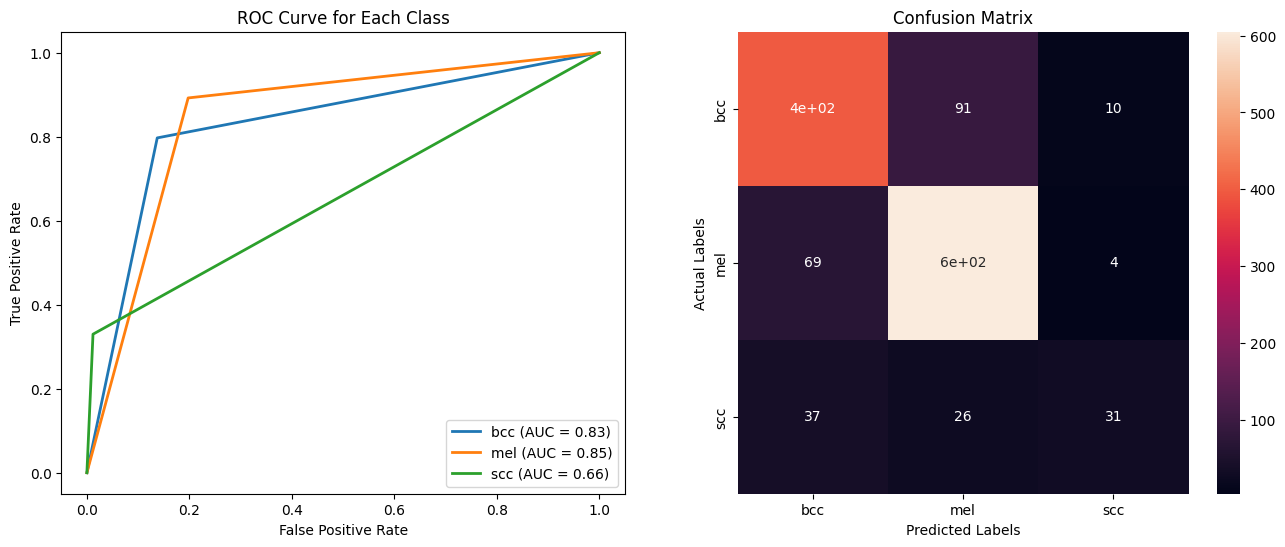

In [24]:
grid = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]}
model = SVC(decision_function_shape='ovr', class_weight='balanced')
# model_fit_predict(model, X_train, y_train, X_val, y_val)
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
(   {   'accuracy': 0.8133858267716535,
        'balanced_accuracy': 0.6731021241811531,
        'bcc_f1': 0.7932067932067933,
        'bcc_precision': 0.7892644135188867,
        'bcc_roc_auc': 0.8299415277691075,
        'bcc_sensitivity': 0.7971887550200804,
        'bcc_specificity': 0.8626943005181347,
        'best_params': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'},
        'kappa': 0.6535007943268943,
        'mel_f1': 0.8642857142857143,
        'mel_precision': 0.8379501385041551,
        'mel_roc_auc': 0.8473476241728455,
        'mel_sensitivity': 0.8923303834808259,
        'mel_specificity': 0.8023648648648649,
        'model': SVC(C=10, class_weight='balanced', decision_function_shape='ovo', gamma=0.1),
        'scc_f1': 0.4460431654676259,
        'scc_precision': 0.6888888888888889,
        'scc_roc_auc': 0.6589412360688957,
        'scc_sensitivity': 0.32978723404255317,
        'scc_specificity': 0.988095238095

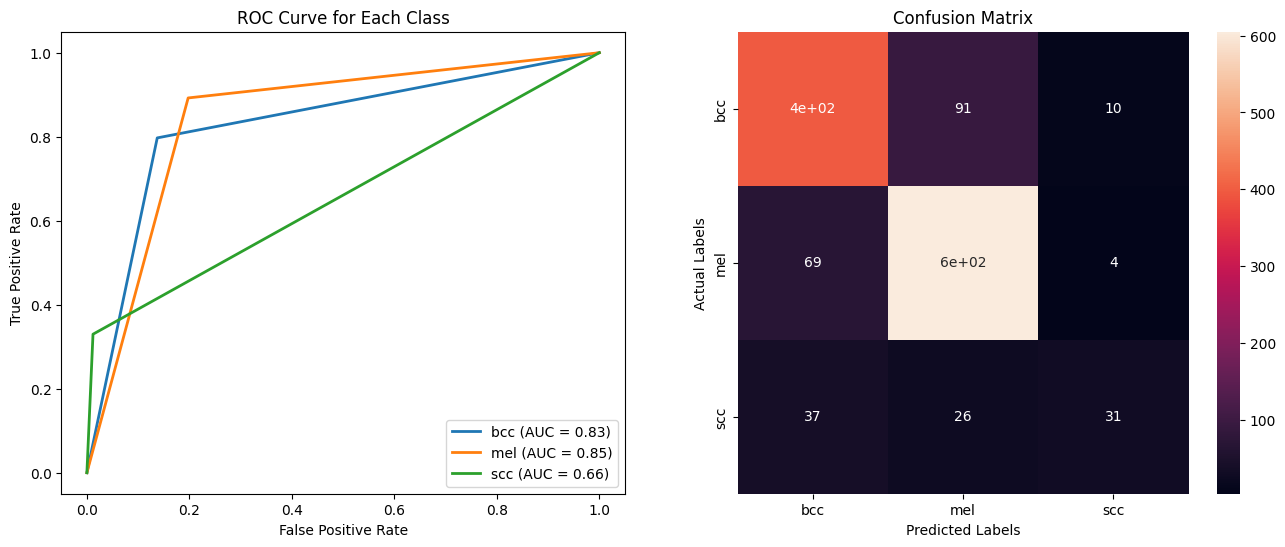

In [25]:
grid = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.001, 0.01, 0.1]}
model = SVC(decision_function_shape='ovo', class_weight='balanced')
# model_fit_predict(model, X_train, y_train, X_val, y_val)
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

### 5. RANDOM FORESTS

In [28]:
print(pd.DataFrame(y_train_encoded).value_counts())

1    2300
0    1993
2     676
Name: count, dtype: int64


Fitting 5 folds for each of 1 candidates, totalling 5 fits
(   {   'accuracy': 0.65748031496063,
        'balanced_accuracy': 0.5984390710396976,
        'bcc_f1': 0.6276243093922652,
        'bcc_precision': 0.6977886977886978,
        'bcc_roc_auc': 0.7054773498137629,
        'bcc_sensitivity': 0.570281124497992,
        'bcc_specificity': 0.8406735751295337,
        'best_params': {   'max_depth': 5,
                           'min_samples_leaf': 4,
                           'min_samples_split': 5,
                           'n_estimators': 100},
        'kappa': 0.43753588896717144,
        'mel_f1': 0.7955974842767296,
        'mel_precision': 0.8518518518518519,
        'mel_roc_auc': 0.7988320178585665,
        'mel_sensitivity': 0.7463126843657817,
        'mel_specificity': 0.8513513513513513,
        'model': RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=4,
                       min_samples_split=5),
        'scc_f1': 0.24793388429752067,
  

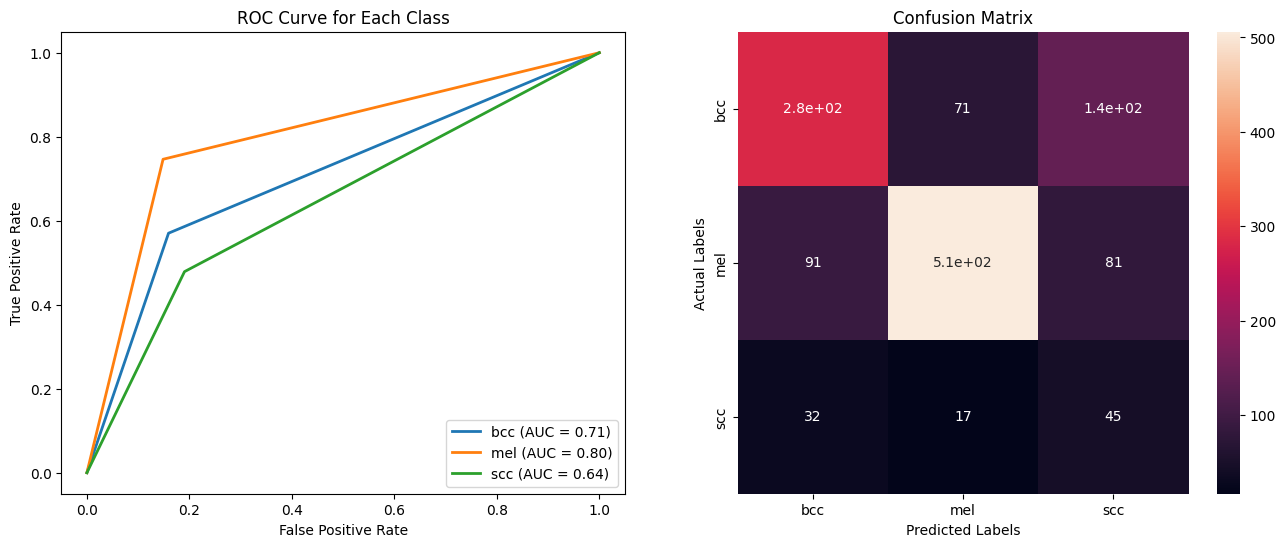

In [29]:
grid = {'n_estimators' : [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model = RandomForestClassifier(class_weight='balanced')
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

### 6. XGBOOST

Fitting 5 folds for each of 1 candidates, totalling 5 fits
(   {   'accuracy': 0.7669291338582677,
        'balanced_accuracy': 0.572209883908949,
        'bcc_f1': 0.7527881040892194,
        'bcc_precision': 0.7006920415224913,
        'bcc_roc_auc': 0.794579873899744,
        'bcc_sensitivity': 0.8132530120481928,
        'bcc_specificity': 0.7759067357512953,
        'best_params': {   'colsample_bytree': 0.9,
                           'learning_rate': 0.01,
                           'max_depth': 5,
                           'n_estimators': 200,
                           'subsample': 0.7},
        'kappa': 0.5669842791057704,
        'mel_f1': 0.8332097850259451,
        'mel_precision': 0.8375558867362146,
        'mel_roc_auc': 0.822393466475325,
        'mel_sensitivity': 0.8289085545722714,
        'mel_specificity': 0.8158783783783784,
        'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,


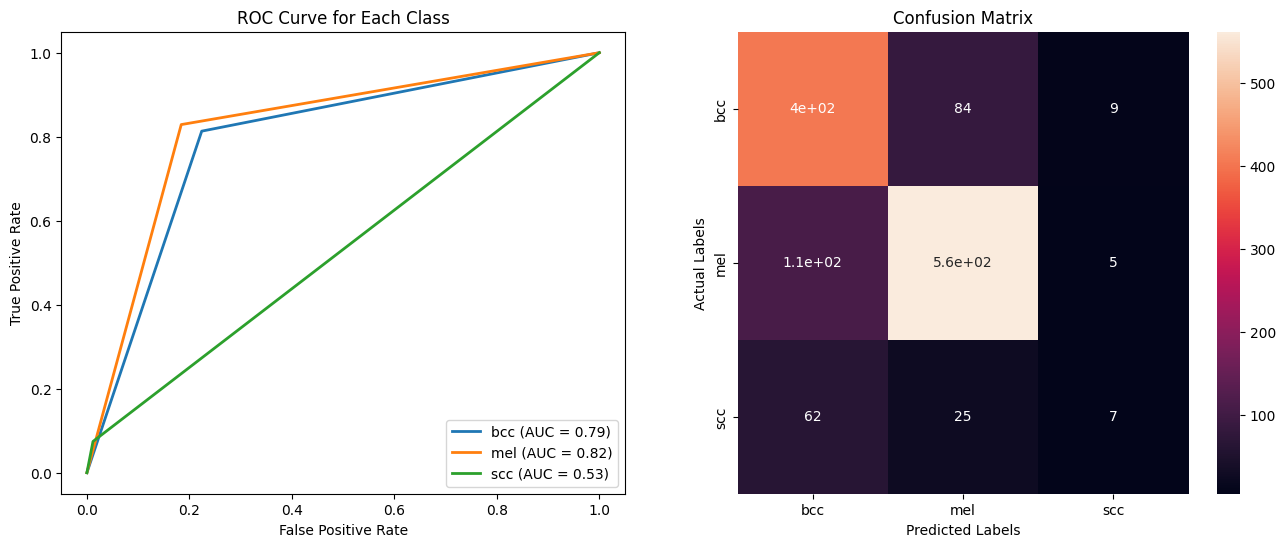

In [32]:
model = XGBClassifier({"device": "cuda:0" if gpu else "cpu"})
grid = {'max_depth': [4, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [200, 300], 'subsample': [0.5, 0.7, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

### 7. LOGISTIC REGRESSION

Fitting 5 folds for each of 1 candidates, totalling 5 fits
(   {   'accuracy': 0.7228346456692913,
        'balanced_accuracy': 0.6272823674034619,
        'bcc_f1': 0.7064989517819705,
        'bcc_precision': 0.7390350877192983,
        'bcc_roc_auc': 0.7612808747945148,
        'bcc_sensitivity': 0.6767068273092369,
        'bcc_specificity': 0.8458549222797928,
        'best_params': {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'},
        'kappa': 0.5257091446128775,
        'mel_f1': 0.8315467075038284,
        'mel_precision': 0.8646496815286624,
        'mel_roc_auc': 0.8286519373355656,
        'mel_sensitivity': 0.8008849557522124,
        'mel_specificity': 0.856418918918919,
        'model': LogisticRegression(C=1, class_weight='balanced', multi_class='ovr'),
        'scc_f1': 0.27142857142857146,
        'scc_precision': 0.20430107526881722,
        'scc_roc_auc': 0.6392024895064408,
        'scc_sensitivity': 0.40425531914893614,
        'scc_specificity': 0.8741496598639455

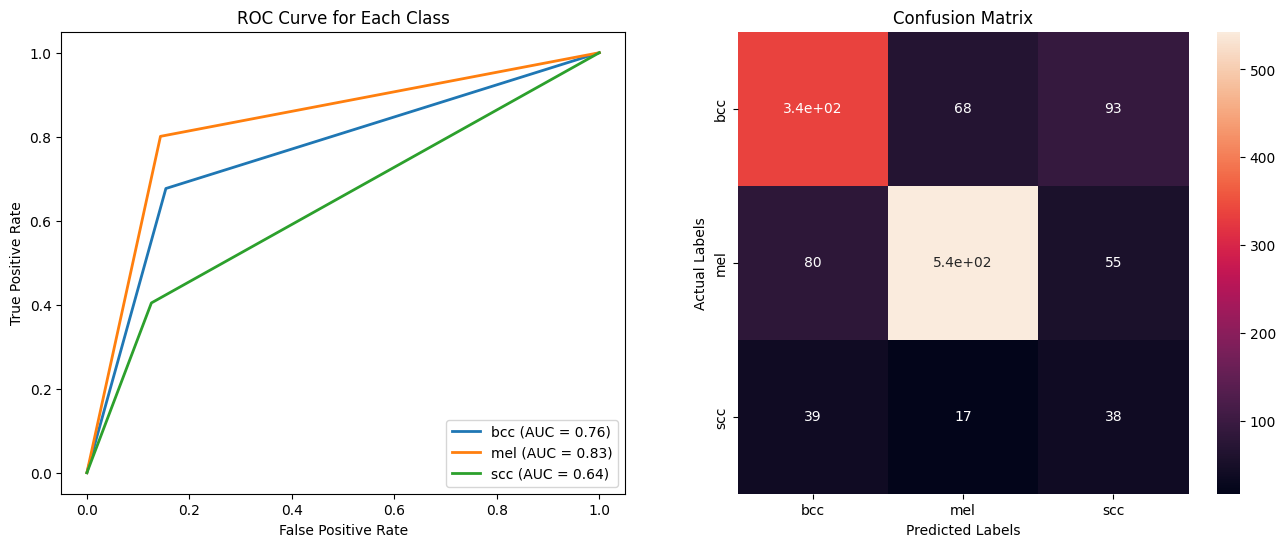

In [17]:
model = LogisticRegression(multi_class = 'ovr', class_weight='balanced')
grid = {'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10], 'solver': ['lbfgs', 'newton-cholesky', 'sag', 'saga']}
model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

### 8. ADABOOST

Fitting 5 folds for each of 1 candidates, totalling 5 fits
(   {   'accuracy': 0.5165354330708661,
        'balanced_accuracy': 0.4821805265372039,
        'bcc_f1': 0.343878954607978,
        'bcc_precision': 0.5458515283842795,
        'bcc_roc_auc': 0.5581444950787606,
        'bcc_sensitivity': 0.25100401606425704,
        'bcc_specificity': 0.8652849740932642,
        'best_params': {   'algorithm': 'SAMME.R',
                           'base_estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1),
                           'learning_rate': 0.01,
                           'n_estimators': 100},
        'kappa': 0.245192065698433,
        'mel_f1': 0.743119266055046,
        'mel_precision': 0.7714285714285715,
        'mel_roc_auc': 0.7367854580243962,
        'mel_sensitivity': 0.7168141592920354,
        'mel_specificity': 0.7567567567567568,
        'model': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                     

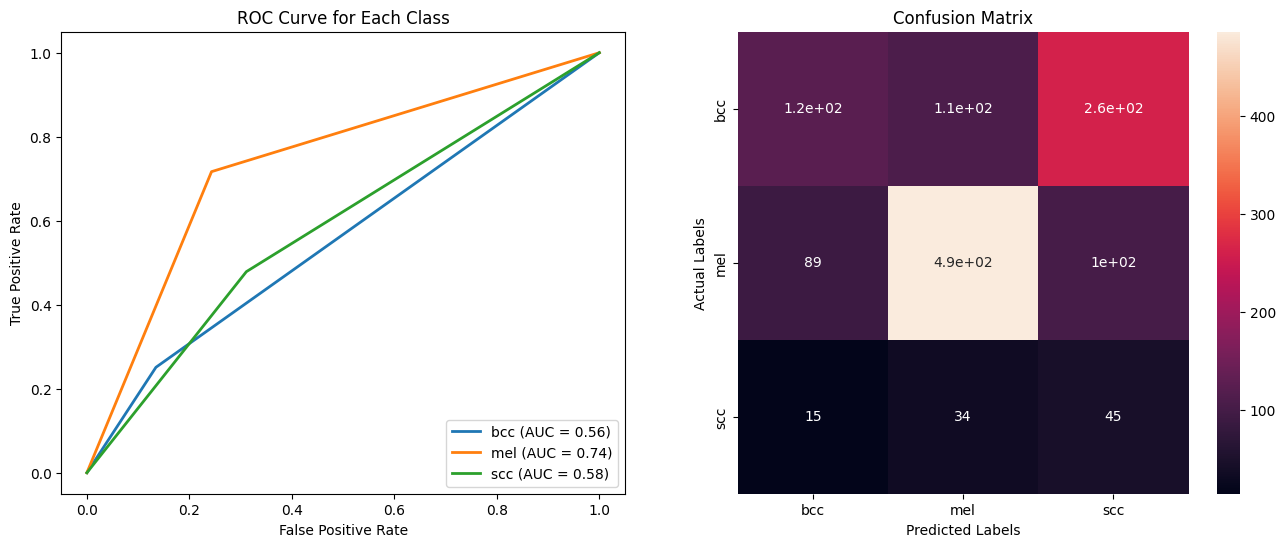

In [21]:
# model = AdaBoostClassifier(random_state=42)
# grid = {'n_estimators' : [100], 'learning_rate': [0.01], 'algorithm': ['SAMME.R'], 'base_estimator': [DecisionTreeClassifier(class_weight='balanced', max_depth=1)]}
# model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

### 9. GRADIENT BOOSTING

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\lui_a\AppData\Local\Temp\ipykernel_17260\428718943.py:40: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


(   {   'accuracy': 0.7362204724409449,
        'balanced_accuracy': 0.5277451990854273,
        'bcc_f1': 0.7206020696142991,
        'bcc_precision': 0.6778761061946903,
        'bcc_roc_auc': 0.766662504942048,
        'bcc_sensitivity': 0.7690763052208835,
        'bcc_specificity': 0.7642487046632125,
        'best_params': {   'learning_rate': 0.01,
                           'loss': 'log_loss',
                           'min_samples_leaf': 4,
                           'min_samples_split': 5,
                           'subsample': 0.7},
        'kappa': 0.5015465004569206,
        'mel_f1': 0.7982646420824294,
        'mel_precision': 0.7829787234042553,
        'mel_roc_auc': 0.7778566730447262,
        'mel_sensitivity': 0.8141592920353983,
        'mel_specificity': 0.7415540540540541,
        'model': GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=4,
                           min_samples_split=5, random_state=42, subsample=0.7),
        'scc_f1': nan,
   

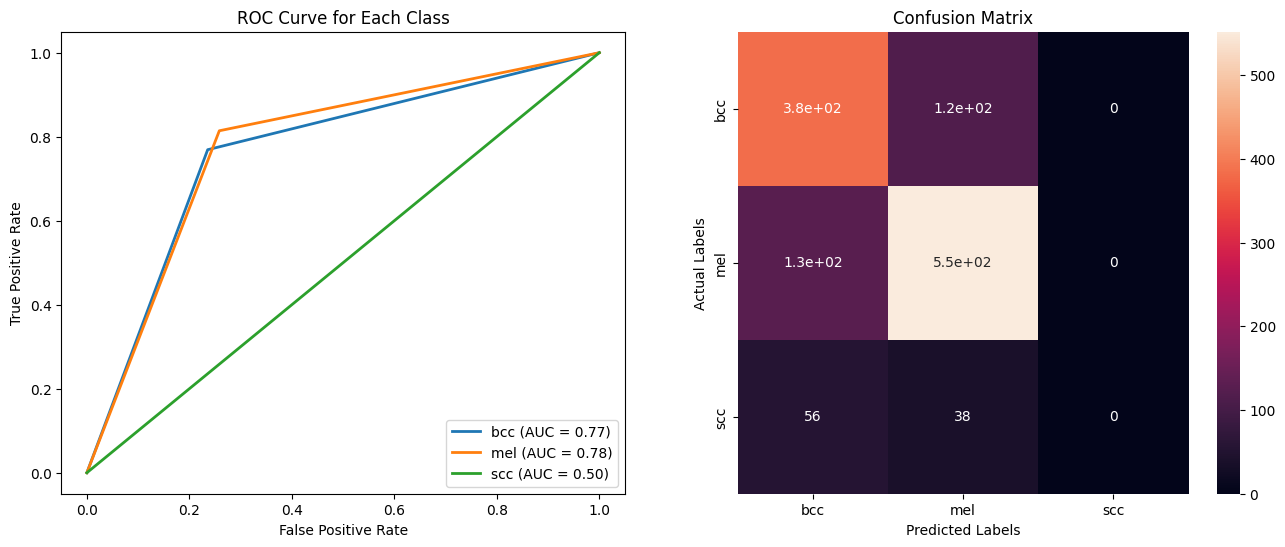

In [26]:
# model = GradientBoostingClassifier(random_state=42)
# grid = {'loss' : ['log_loss'], 'learning_rate': [0.01], 'subsample': [0.7], 'min_samples_split': [5], 'min_samples_leaf': [4]}
# model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)

### 10. EXTREMELY RANDOMNIZED TREES

Fitting 5 folds for each of 1 candidates, totalling 5 fits
(   {   'accuracy': 0.6283464566929133,
        'balanced_accuracy': 0.5590783393411719,
        'bcc_f1': 0.5903083700440529,
        'bcc_precision': 0.6536585365853659,
        'bcc_roc_auc': 0.6771073933037851,
        'bcc_sensitivity': 0.5381526104417671,
        'bcc_specificity': 0.8160621761658031,
        'best_params': {   'criterion': 'entropy',
                           'max_depth': 5,
                           'min_samples_leaf': 4,
                           'min_samples_split': 5,
                           'n_estimators': 100},
        'kappa': 0.38748150509682755,
        'mel_f1': 0.7695924764890282,
        'mel_precision': 0.8210702341137124,
        'mel_roc_auc': 0.7717227736586145,
        'mel_sensitivity': 0.724188790560472,
        'mel_specificity': 0.8192567567567568,
        'model': ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
                     criterion='entropy', max_depth=

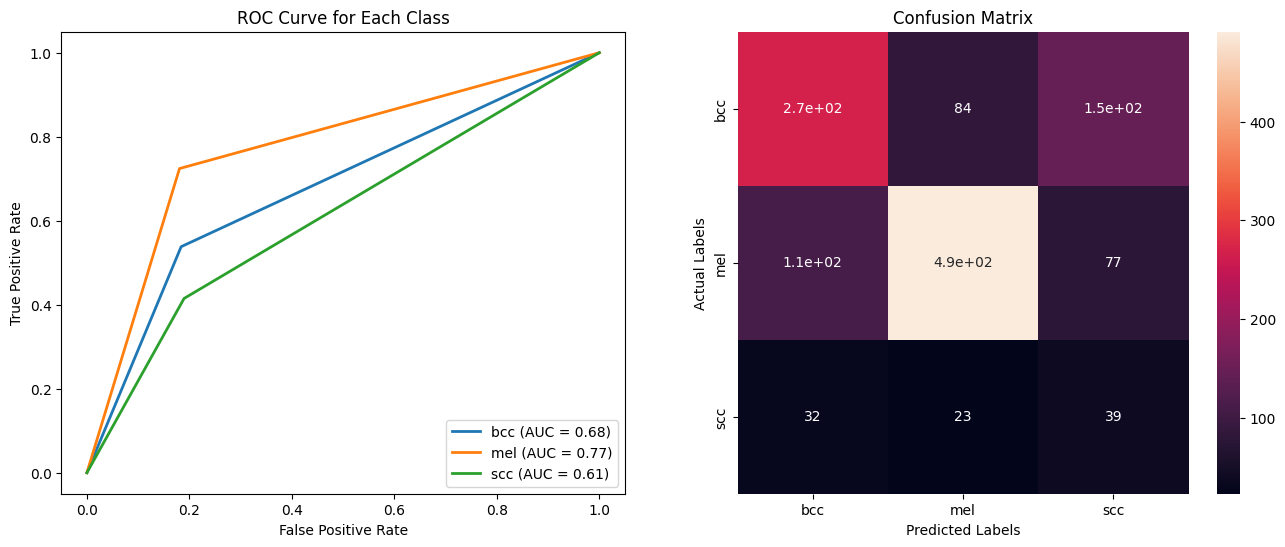

In [23]:
# model = ExtraTreesClassifier(class_weight='balanced', bootstrap=True)
# grid = {'n_estimators' : [100], 'max_depth': [5], 'criterion': ['entropy'], 'min_samples_split': [5], 'min_samples_leaf': [4]} # still takes a lot of time
# model_fit_predict(model, grid, 'accuracy', X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded)